In [0]:
!bash setup_v2.sh

In [0]:
from fastai2.vision.all import *
from fastai2.data.all import *

# Download dataset

## PETS dataset for test

In [3]:
path = untar_data(URLs.PETS)

In [0]:
dblock = dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=RegexLabeller(r'/([^/]+)_\d+.jpg$'),
                   splitter=RandomSplitter(),
                   item_tfms=Resize(sz),
                   batch_tfms=[*aug_transforms(max_rotate=5.0,max_lighting=0.), Normalize.from_stats(*imagenet_stats)])

In [0]:
dls = dblock.dataloaders(path/'images', bs=bs)

## Wildfire-v2 dataset

In [0]:
source_path = Path('data/wildfire-v2/')

# EDA

In [0]:
from tqdm import tqdm

In [0]:
import seaborn as sns

In [0]:
image_files = get_image_files(path)

In [27]:
data = []
for path in tqdm(image_files, maxinterval=len(image_files)):
  shape = PILImage.create(path).shape
  data.append({'image_path': str(path), 'height': shape[0], 'width': shape[1], 'category': path.parent.stem})

100%|██████████| 2473/2473 [00:52<00:00, 46.71it/s]


In [28]:
df = pd.DataFrame(data); df.head()

,image_path,height,width,category
0,data/wildfire-v2/test/smoke/64.jpg,398,600,smoke
1,data/wildfire-v2/test/smoke/frame-1320.png,720,1280,smoke
2,data/wildfire-v2/test/smoke/149_wildfire24.jpg,600,800,smoke
3,data/wildfire-v2/test/smoke/281_ap_18236125742506.jpg,720,1280,smoke
4,data/wildfire-v2/test/smoke/frame-2160 (2).png,720,1280,smoke


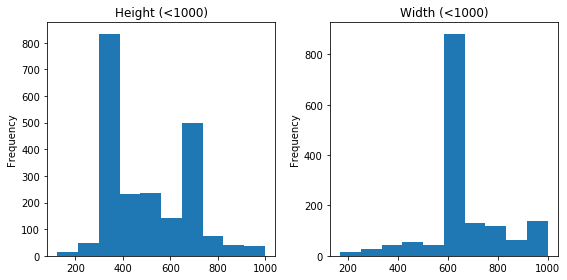

In [29]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

#Height plot
df.height[df['height'] < 1000].plot.hist(ax=ax1)
ax1.set_title('Height (<1000)')

#Width plot
df.width[df['width'] < 1000].plot.hist(ax=ax2)
ax2.set_title('Width (<1000)')
plt.tight_layout()

In [30]:
df.width.describe()

count    2473.000000
mean     1038.817226
std       769.580468
min       170.000000
25%       600.000000
50%       780.000000
75%      1280.000000
max      8256.000000
Name: width, dtype: float64

In [31]:
df.height.describe()

count    2473.000000
mean      658.370805
std       574.791419
min       124.000000
25%       300.000000
50%       515.000000
75%       720.000000
max      5568.000000
Name: height, dtype: float64

In [33]:
df.category.value_counts()

fire        755
non-fire    754
smoke       564
cloud       400
Name: category, dtype: int64

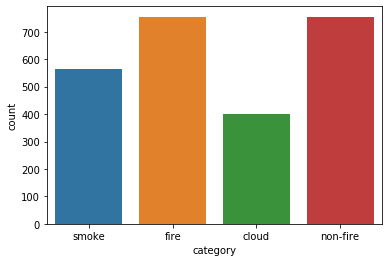

In [36]:
sns.countplot(x='category',data=df);

# Dataloaders

In [0]:
bs, sz = 64, 128

In [0]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=47),
                   item_tfms=Resize(sz),
                   batch_tfms=[*aug_transforms(max_rotate=5.0,max_lighting=0.), Normalize.from_stats(*imagenet_stats)])

In [0]:
dls = dblock.dataloaders(source_path/'train', bs=bs)

In [47]:
test_imgs = get_image_files(source_path/'test'); test_imgs

(#455) [Path('data/wildfire-v2/test/smoke/64.jpg'),Path('data/wildfire-v2/test/smoke/frame-1320.png'),Path('data/wildfire-v2/test/smoke/149_wildfire24.jpg'),Path('data/wildfire-v2/test/smoke/281_ap_18236125742506.jpg'),Path('data/wildfire-v2/test/smoke/frame-2160 (2).png'),Path('data/wildfire-v2/test/smoke/122_indonesianfo.jpg'),Path('data/wildfire-v2/test/smoke/200_190825224610-10-amazon-fire-0825-exlarge-169.jpg'),Path('data/wildfire-v2/test/smoke/frame-1136.png'),Path('data/wildfire-v2/test/smoke/frame-4720.png'),Path('data/wildfire-v2/test/smoke/268_Tim-Fire-1.jpg')...]

In [0]:
test_dl = dls.test_dl(test_imgs, with_labels=True)

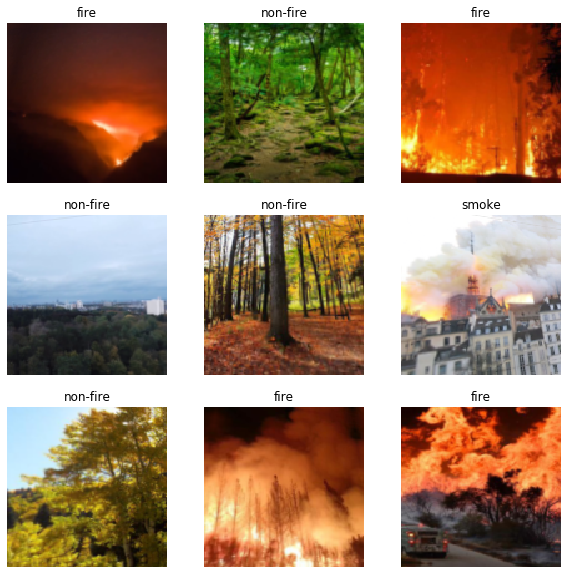

In [65]:
dls.show_batch(figsize=(10,10))

# Architecture

In [0]:
from utils import *

## XResnet50

Since xresnet50 is from fastai2 only, there's little change in splits and head

In [0]:
exp_name='xresnet50-sa-mish'

In [0]:
arch = partial(xresnet50 ,sa=True, act_cls=Mish)

In [69]:
arch_summary(arch)

(0) ConvLayer   : 3   layers (total: 3)
(1) ConvLayer   : 3   layers (total: 6)
(2) ConvLayer   : 3   layers (total: 9)
(3) MaxPool2d   : 1   layers (total: 10)
(4) Sequential  : 33  layers (total: 43)
(5) Sequential  : 42  layers (total: 85)
(6) Sequential  : 62  layers (total: 147)
(7) Sequential  : 32  layers (total: 179)
(8) AdaptiveAvgPool2d: 1   layers (total: 180)
(9) Flatten     : 1   layers (total: 181)
(10) Dropout     : 1   layers (total: 182)
(11) Linear      : 1   layers (total: 183)


# Callbacks

In [0]:
saved_model = SaveModelCallback(fname=exp_name)
early_stopping = EarlyStoppingCallback(min_delta=2e-2, patience=3)

# Learner

In [0]:
del learn

In [0]:
learn = cnn_learner(dls,arch,opt_func=ranger,
                    metrics=[error_rate, Precision(average='micro'), Recall(average='micro'), F1Score(average='micro')],
                    cbs=[saved_model, early_stopping],
                    model_dir=Path('/content/models'))

In [73]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 64 x 64    864        False     
________________________________________________________________
BatchNorm2d          64 x 32 x 64 x 64    64         True      
________________________________________________________________
Mish                 64 x 32 x 64 x 64    0          False     
________________________________________________________________
Conv2d               64 x 32 x 64 x 64    9,216      False     
________________________________________________________________
BatchNorm2d          64 x 32 x 64 x 64    64         True      
________________________________________________________________
Mish                 64 x 32 x 64 x 64    0          False     
________________________________________________________________
Conv2d               64 x 64 x 64 x 64    18,432     False     
_________________________________________________

(0.05248074531555176, 0.0691830962896347)

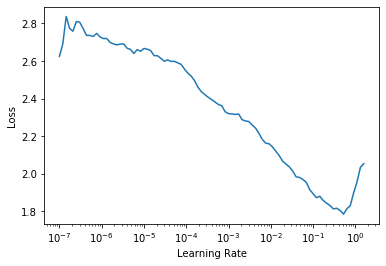

In [74]:
learn.lr_find()

In [75]:
learn.fit_flat_cos(4,lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,f1_score,time
0,1.818833,0.957747,0.349876,0.650124,0.650124,0.650124,00:50
1,1.308150,0.989127,0.295285,0.704715,0.704715,0.704715,00:48
2,1.085625,1.145971,0.280397,0.719603,0.719603,0.719603,00:48
3,0.953603,0.989596,0.267990,0.732010,0.732010,0.732010,00:48


No improvement since epoch 0: early stopping


(2.5118865210060903e-08, 3.6307804407442745e-07)

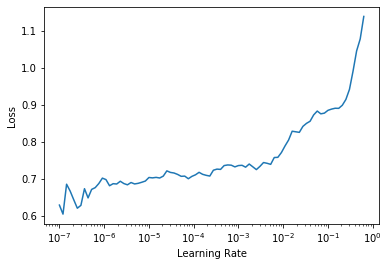

In [92]:
learn.unfreeze()
learn.lr_find()

In [78]:
learn.fit_flat_cos(4,lr=(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,f1_score,time
0,1.108225,0.968227,0.297767,0.702233,0.702233,0.702233,00:50
1,0.970048,0.794710,0.267990,0.732010,0.732010,0.732010,00:50
2,0.892778,0.815615,0.250620,0.749380,0.749380,0.749380,00:50
3,0.837769,0.773093,0.233251,0.766749,0.766749,0.766749,00:49


In [0]:
test_dl.bs=1

In [0]:
res = learn.validate(dl=test_dl)

In [85]:
metrics=['Loss','Error Rate','Precision', 'Recall', 'F1 Score']
for score,lbl in zip(res,metrics):
  print(f'{lbl:<10}: {score * 100:.2f}')

Loss      : 85.51
Error Rate: 25.49
Precision : 74.51
Recall    : 74.51
F1 Score  : 74.51


In [86]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)

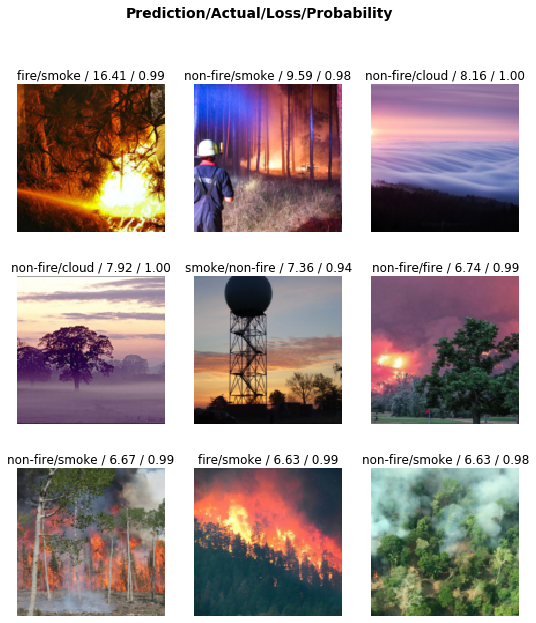

In [89]:
interp.plot_top_losses(k=9)

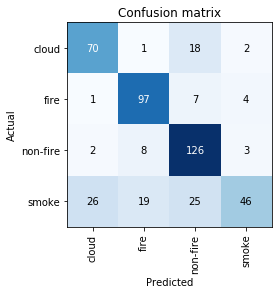

In [90]:
interp.plot_confusion_matrix()

In [91]:
interp.most_confused()

[('smoke', 'cloud', 26),
 ('smoke', 'non-fire', 25),
 ('smoke', 'fire', 19),
 ('cloud', 'non-fire', 18),
 ('non-fire', 'fire', 8),
 ('fire', 'non-fire', 7),
 ('fire', 'smoke', 4),
 ('non-fire', 'smoke', 3),
 ('cloud', 'smoke', 2),
 ('non-fire', 'cloud', 2),
 ('cloud', 'fire', 1),
 ('fire', 'cloud', 1)]

In [0]:
m = learn.model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


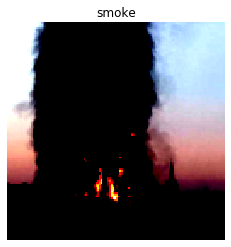

In [125]:
x,y = test_dl.one_batch()
TensorImage(x[0]).show(title=dls.vocab[y.item()]);

In [136]:
dls.train.one_batch()

(TensorImage([[[[-1.9468e+00, -1.9528e+00, -1.9636e+00,  ..., -2.0330e+00,
            -2.0460e+00, -2.0438e+00],
           [-1.9501e+00, -1.9638e+00, -1.9794e+00,  ..., -2.0471e+00,
            -2.0494e+00, -2.0494e+00],
           [-1.9479e+00, -1.9570e+00, -1.9636e+00,  ..., -2.0492e+00,
            -2.0485e+00, -2.0494e+00],
           ...,
           [-2.0666e+00, -2.0660e+00, -2.0496e+00,  ..., -1.3041e+00,
            -1.2611e+00, -1.2556e+00],
           [-2.0683e+00, -2.0590e+00, -2.0503e+00,  ..., -1.6739e+00,
            -1.6226e+00, -1.5858e+00],
           [-2.0735e+00, -2.0702e+00, -2.0824e+00,  ..., -1.6972e+00,
            -1.6946e+00, -1.7044e+00]],
 
          [[-1.8643e+00, -1.8782e+00, -1.8951e+00,  ..., -1.9489e+00,
            -1.9623e+00, -1.9600e+00],
           [-1.8641e+00, -1.8782e+00, -1.8790e+00,  ..., -1.9633e+00,
            -1.9657e+00, -1.9657e+00],
           [-1.8619e+00, -1.8713e+00, -1.8780e+00,  ..., -1.9655e+00,
            -1.9648e+00, -1.9657e+